# Sequentializer

Here I analyze the results given from my sequentializer pipeline. In this particular section, I analyze results of predicting her2 positivity with five machine-learning algorithms given the 87 genes that are believed to be part of the HER2 pathway sequentially. That is to say testing was performed using only data from one gene once per gene, and the test with the highest AUROC was selected. The tests were then performed using the selected gene and one of the remaining 86 genes, performed once per remaining gene. The selected gene was then appended to the list of the previously selected gene(s). This was performed until 10 genes were chosen. In the case of the initial testing, ERBB2 was given as a default starting point, so the reader may notice 11 genes amongst the selected genes.

Algorithms and normalization methods were selected based on my prior tests detailed here: [chapter 1](https://nbviewer.jupyter.org/github/zence/SCCR/blob/Kumiko/notebooks/scaling_methods_p1.ipynb), [chapter 2](https://nbviewer.jupyter.org/github/zence/SCCR/blob/Kumiko/notebooks/scaling_methods_p2.ipynb), [chapter 3](https://nbviewer.jupyter.org/github/zence/SCCR/blob/Kumiko/notebooks/scaling_methods_p3.ipynb)

I later performed tests, allowing the algorithms to select all 10 genes without a starting point, meaning no genes were given to start testing. Thus, the resulting selected genes were all selected by the algorithms.

In this notebook, I analyze the resulting data and score genes based on two criteria:

1. Location in selected genes list
  - In this case, order will always be important since the next gene will always give the best AUC out of the remaining genes
  - Initial scores are calculated as the position from the end of the selected genes +1 (this allows the last positioned gene to still be ranked higher than genes which were not selected)
2. Weight of instance
  - Weights of each instance are calculated by normalizing AUCs (between 0 and 1) and adding 1. Thus, the lowest AUC results in a weight of 1 and the highest AUC results in a weight of 2. This is to ensure that AUC is taken into account, but is not the sole determining factor.
  - Initial scores are multiplied by instance weight. Thus, the better AUCs result in higher importance and scores.
  
In my second round of testing, I took AUCs as selected gene lists were being built. Thus, position scores are more heavily influenced by whether or not that particular position helped or harmed AUCs.

In [104]:
require(readr)
require(ggplot2)

Loading required package: ggplot2


This is a simple normalization method that really should be part of base r, but it is simple enough to type up.

In [6]:
normalize <- function(x){(x-min(x))/(max(x)-min(x))}

My initial scoring function. This bases scores only on the end results and is used in the first part of this analysis.

In [135]:
get_score <- function(gene.vec, weight.df){
    scores <- c()
    for (gene in gene.vec){
        score <- 0
        cur.score <- 0
        for (i in 1:nrow(weight.df)){
            gene.group <- weight.df$genes[[i]]
            cur.score <- match(gene, gene.group)
            if (is.na(cur.score)){
                cur.score <- 0
            } else {
                cur.score <- (length(gene.group) - cur.score + 1) * weight.df$weight[i] # + 1 to give points to 11th position
            }
            score <- score + cur.score
            #print(cur.score)
        }
        scores <- c(scores, score)
    }
    return(scores)
}

My second scoring function. This test is slightly more refined as it gets weights for each position in the selected genes list. Thus, weight is determined also by how AUC was affected in an instance.

In [143]:
get_seqd_score <- function(gene.vec, weight.df){
    scores <- c()
    for (gene in gene.vec){
        score <- 0
        cur.score <- 0
        for (i in 1:nrow(weight.df)){
            gene.group <- weight.df$genes[[i]]
            cur.score <- match(gene, gene.group)
            if (is.na(cur.score) | cur.score < length(gene.group)){
                cur.score <- 0
            } else {
                cur.score <- (11 - cur.score) * weight.df$weight[i] # 11 so the last place position gets 1 point
            }
            score <- score + cur.score
            #print(cur.score)
        }
        scores <- c(scores, score)
    }
    return(scores)
}

## Initial analysis

Here I score and rank genes based on positioning within the selected genes of final results.

In [28]:
best.genes <- as.data.frame(read_tsv("../results/best_genes.tsv"))

Parsed with column specification:
cols(
  model = col_character(),
  genes = col_character(),
  auc = col_double()
)


In [29]:
best.genes

model,genes,auc
LR,"ERBB2,PIK3R1,ABL2,BAD,ABL1,MAPK9,SOS2,STAT5B,CBL,SRC,CBLC",0.7921931
rbfSVM,"ERBB2,SRC,PIK3R5,SHC4,ABL1,MAPK9,BTC,AKT1,CAMK2A,RPS6KB1,CAMK2G",0.7585523
RF,"ERBB2,PRKCB,MAPK9,MAP2K2,SHC2,CBLC,NRAS,PIK3CD,PIK3R2,JUN,HBEGF",0.7792454
GradientBoost,"ERBB2,SRC,PIK3CG,MAPK1,CAMK2G,AKT1,STAT5B,MAP2K4,ERBB4,PLCG1,STAT5A",0.7803439
LinearSVM,"ERBB2,RPS6KB1,ABL1,ABL2,AKT1,AKT3,BTC,CAMK2A,AKT2,ARAF,SHC3",0.7585523


In [30]:
best.genes$weight <- normalize(best.genes$auc) + 1

In [34]:
best.genes$genes <- strsplit(best.genes$genes, split = ',')

In [38]:
best.genes$genes[[1]]

[1] "ERBB2"  "PIK3R1" "ABL2"   "BAD"    "ABL1"   "MAPK9"  "SOS2"   "STAT5B"
 [9] "CBL"    "SRC"    "CBLC"

In [41]:
all.genes <- as.data.frame(read_tsv("../data/genes.txt", col_names = F))
names(all.genes) <- c("gene")

Parsed with column specification:
cols(
  X1 = col_character()
)


In [88]:
all.genes$score <- get_score(all.genes$gene, best.genes)

In [117]:
all.genes <- all.genes[order(all.genes$score, decreasing = T),]
row.names(all.genes) <- seq(length = nrow(all.genes))

#all.genes

top.genes <- all.genes[which(all.genes$score > 0),]

top.genes$gene <- factor(top.genes$gene, levels = top.genes$gene[order(top.genes$score, decreasing = T)])

In [118]:
top.genes

gene,score
ERBB2,72.628893
MAPK9,27.920944
ABL1,26.000000
SRC,25.829942
ABL2,23.000000
PIK3R1,18.000000
AKT1,17.238856
PRKCB,14.536062
BAD,14.000000
PIK3CG,13.182170


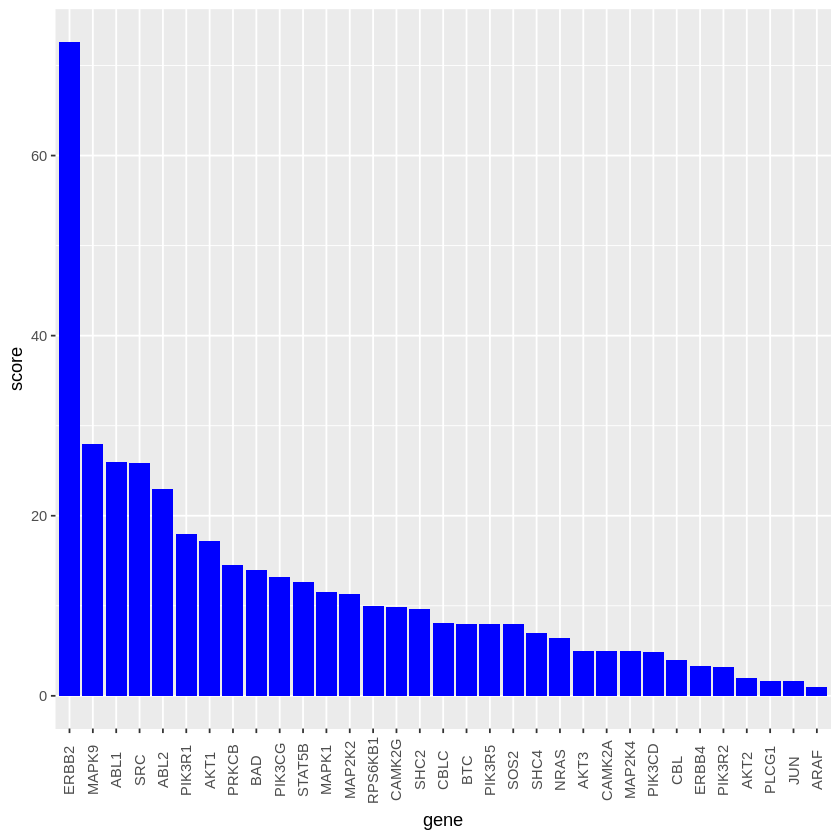

In [123]:
gbar <- ggplot(top.genes, aes(x = gene, y = score, fill = 'gene'))
ggbar <- gbar + geom_bar(stat = 'identity') +
        scale_fill_manual(values = "blue", guide = F) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

ggbar

ERBB2 has such a high score because it is always at the beginning of the selected genes. Thus, no matter the weight, it always scores the highest. This seems unfair since I put ERBB2 there. Thus, I was curious to see if, given free reign on the 87 genes, the algorithms would even score ERBB2 nearly as high as I put it.

## Secondary analysis

In my secondary tests, I reran the original, but this time I did not give the algorithms any selected genes to begin with, but instead allowed them to select all 10 genes on their own. I also kept track of AUCs as the lists of selected genes were being built in order to see whether adding a particular gene helped or hurt AUC.

In [133]:
seqd.genes <- as.data.frame(read_tsv('../results/seqd_genes.tsv'))

seqd.genes$weight <- normalize(seqd.genes$auc) + 1

seqd.genes$genes <- strsplit(seqd.genes$genes, split = ',')

Parsed with column specification:
cols(
  model = col_character(),
  genes = col_character(),
  auc = col_double()
)


Let's take a look at the selected genes. Here, they can be found unfolding in the `genes` column.

In [194]:
seqd.genes

model,genes,auc,weight,series
GradientBoost,ERBB2,0.7448325,1.096998,1
GradientBoost,"ERBB2, SRC",0.7638438,1.477200,2
GradientBoost,"ERBB2 , SRC , PIK3CG",0.7740249,1.680807,3
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1",0.7761378,1.723062,4
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G",0.7798242,1.796785,5
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G, AKT1",0.7791484,1.783271,6
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G, AKT1 , STAT5B",0.7804552,1.809406,7
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G, AKT1 , STAT5B, MAP2K4",0.7776946,1.754197,8
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G, AKT1 , STAT5B, MAP2K4, ERBB4",0.7786037,1.772377,9
GradientBoost,"ERBB2 , SRC , PIK3CG, MAPK1 , CAMK2G, AKT1 , STAT5B, MAP2K4, ERBB4 , PLCG1",0.7835719,1.871735,10


ERBB2 was selected as the first gene in _every_ case without any prompting. Thus, we can trust these tests to find the most closely correlated genes.

In [144]:
all.seqd.genes <- as.data.frame(read_tsv("../data/genes.txt", col_names = F))
names(all.seqd.genes) <- c("gene")

all.seqd.genes$score <- get_seqd_score(all.seqd.genes$gene, seqd.genes)

Parsed with column specification:
cols(
  X1 = col_character()
)


In [147]:
all.seqd.genes <- all.seqd.genes[order(all.seqd.genes$score, decreasing = T),]
row.names(all.seqd.genes) <- seq(length = nrow(all.seqd.genes))

#all.genes

top.seqd.genes <- all.seqd.genes[which(all.seqd.genes$score > 0),]

top.seqd.genes$gene <- factor(top.seqd.genes$gene, levels = top.seqd.genes$gene[order(top.seqd.genes$score, decreasing = T)])

In [148]:
top.seqd.genes

gene,score
ERBB2,60.310898
MAPK9,29.238520
SRC,28.960219
ABL1,28.813986
ABL2,21.633389
AKT1,21.148649
PRKCB,14.067389
RPS6KB1,13.548626
PIK3R1,13.517341
PIK3CG,13.446457


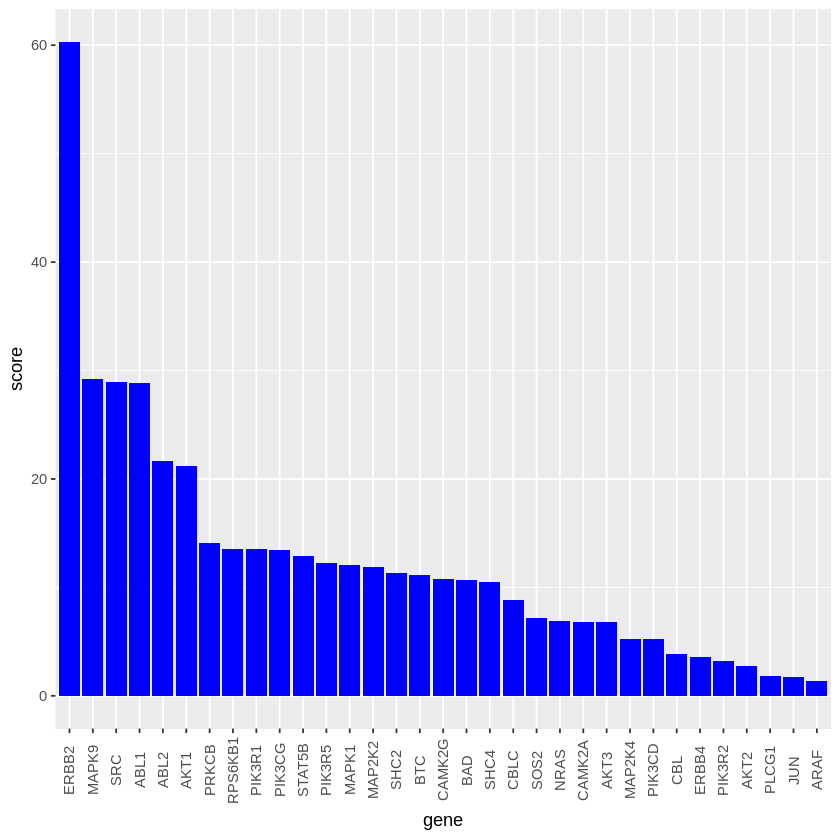

In [149]:
gbar <- ggplot(top.seqd.genes, aes(x = gene, y = score, fill = 'gene'))
ggbar <- gbar + geom_bar(stat = 'identity') +
        scale_fill_manual(values = "blue", guide = F) +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5))

ggbar

I would just like to point out here that the top five genes here and the top five genes from the initial tests are the same (although not necessarily in the same order, as we see that SRC and ABL1 are now switched). Also, since ERBB2 was always selected first, it has a significantly greater score than the rest.

Now, let's look at how AUC was affected at each point while building the selected genes lists.

In [187]:
seqd.genes$series <- as.integer(lapply(seqd.genes$genes, length))


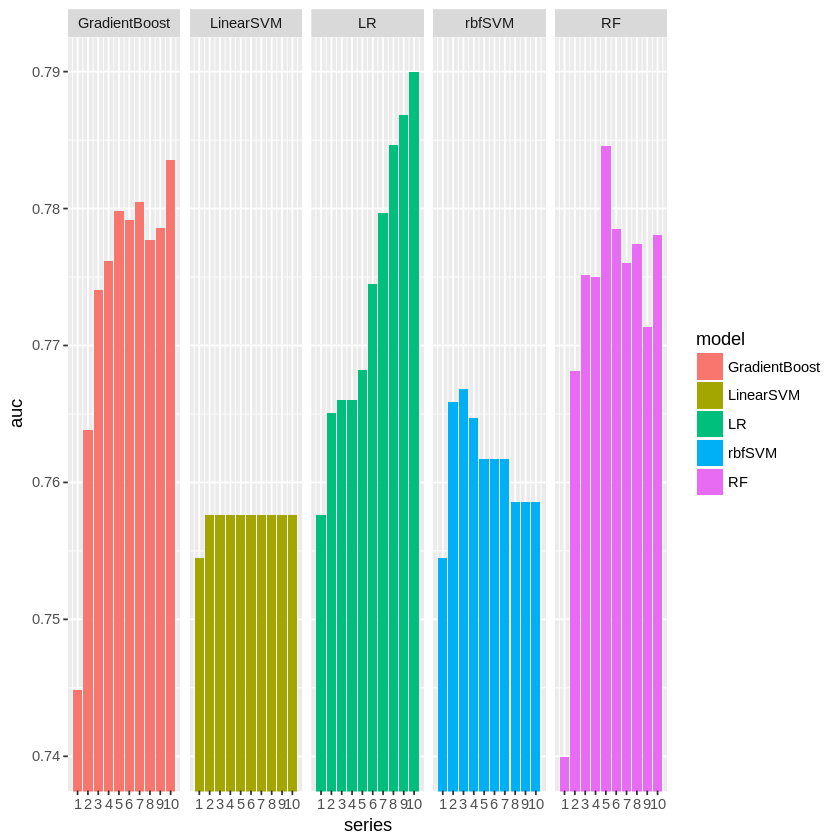

In [197]:
gbar <- ggplot(seqd.genes, aes(x = series, y = auc, fill = model))
ggbar <- gbar + geom_bar(stat = "identity") + facet_grid(. ~ model) +
            coord_cartesian(ylim = c(0.74, 0.79)) +
            scale_x_continuous(breaks = seq(1, 10))

ggbar

>__NOTE:__ There is not much space, so I just used numbers to represent which gene (position) within the list of selected genes was added at the time of AUC calculation. For reference, I will add the selected genes of each group. e.g. If I were looking at GradientBoosting, series 1 would be `ERBB2` and series 2 would be `SRC` and so forth.

`GradientBoosting: ERBB2, SRC, PIK3CG, MAPK1, CAMK2G, AKT1, STAT5B, MAP2K4, ERBB4 , PLCG1`

`LinearSVM: ERBB2, RPS6KB1, ABL1, ABL2, AKT1, AKT3, BTC, CAMK2A, AKT2, ARAF`

`Logistic Regression (LR): ERBB2, PIK3R1, ABL2, BAD, ABL1, MAPK9, SOS2, STAT5B, CBL, SRC`

`rbfSVM: ERBB2, SRC, PIK3R5, SHC4, ABL1, MAPK9, BTC, AKT1, CAMK2A, RPS6KB1`

`Random Forest (RF): ERBB2, PRKCB, MAPK9, MAP2K2, SHC2, CBLC, NRAS, PIK3CD, PIK3R2, JUN`

One interesting trend here is that each algorithm actually performed poorest when using _just ERBB2_. After that, not much can be pulled from this graph other than simply being able to visualize the impact that each gene had on AUC. However, I still believe that the previous graph (the one comparing gene scores) is a more succinct summary of the influence of a gene and its importance in accurately predicting HER2 positivity.